In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import learning_curve
# KNN Model
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter

In [15]:
import pickle 

# # Đọc dữ liệu bệnh tim, phân loại nhị phân
# with open('preprocessing/heart/X.pkl', 'rb') as f:
#     X = pickle.load(f)
# with open('preprocessing/heart/y.pkl', 'rb') as f:
#     y = pickle.load(f)

with open('preprocessing/cirrhosis/X.pkl', 'br') as f:
    X = pickle.load(f)

with open('preprocessing/cirrhosis/y.pkl', 'rb') as f:
    y = pickle.load(f)

print('So luong du lieu: ', len(X))
print('So luong nhan: ', len(y))
X[0:5]

So luong du lieu:  412
So luong nhan:  412


,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,...,Drug_1,Ascites_0,Ascites_1,Hepatomegaly_0,Hepatomegaly_1,Spiders_0,Spiders_1,Edema_0,Edema_1,Edema_2
0,0.736012,2.547971,-0.547614,-2.125657,0.779134,-0.141082,0.312051,0.879630,-0.704207,1.432617,...,0,0,1,0,1,0,1,0,0,1
1,0.545297,-0.480933,-0.335883,1.511284,-0.578348,2.909990,-0.181213,-0.671780,-0.376028,-0.131446,...,0,1,0,0,1,0,1,1,0,0
2,1.880301,-0.413122,-0.986570,-0.047405,1.497801,-0.787113,-0.532939,-1.281263,-1.117076,1.237109,...,0,1,0,1,0,1,0,0,1,0
3,0.354582,-0.322707,-0.635405,-2.267356,-0.445261,2.225799,-1.249112,-0.597904,-0.778311,-0.424708,...,0,1,0,0,1,0,1,0,1,0
4,-1.171138,0.038953,-0.454659,0.070678,0.606122,-0.703806,-0.188684,-0.967287,-1.275872,0.161816,...,1,1,0,0,1,0,1,1,0,0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=10)
X_train

,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,...,Drug_1,Ascites_0,Ascites_1,Hepatomegaly_0,Hepatomegaly_1,Spiders_0,Spiders_1,Edema_0,Edema_1,Edema_2
211,-0.312921,-0.458330,-0.697376,1.133420,-1.150620,-0.487209,-0.439051,-0.468619,-0.354855,-0.815723,...,1,1,0,1,0,1,0,1,0,0
385,1.784944,-0.639160,0.252318,-1.110147,-0.071288,0.054608,0.037051,0.116853,-0.884175,0.161816,...,1,1,0,1,0,1,0,1,0,0
101,0.545297,-0.526141,-0.614749,1.109803,0.992072,-0.717243,-1.221450,-0.745657,-1.360564,-0.620215,...,0,1,0,1,0,1,0,1,0,0
120,1.594229,-0.435726,-1.115675,-0.992065,-0.325484,-0.466785,-1.534410,-1.392078,-0.460719,2.410156,...,1,0,1,0,1,1,0,0,0,1
207,1.022084,0.151972,0.149551,-0.708667,-0.525113,-0.290497,0.625011,0.122394,-1.064144,-0.717969,...,0,1,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,-0.598993,-0.571349,-0.645734,1.369585,-0.325484,2.101215,-1.327251,-0.117705,0.373489,-0.131446,...,0,1,0,1,0,1,0,1,0,0
321,0.163867,-0.390518,0.252318,-0.189104,-0.071288,0.054608,0.037051,0.116853,-0.111368,-0.424708,...,1,1,0,1,0,1,0,1,0,0
354,-0.885065,0.513632,-0.151005,-2.810535,0.394514,0.019834,0.161629,0.087303,2.757548,-0.326954,...,0,1,0,0,1,1,0,1,0,0
16,0.163867,-0.119273,-0.480480,-0.826749,0.819060,-0.240513,-0.094796,0.066987,-0.344269,-0.229200,...,1,1,0,0,1,1,0,1,0,0


In [17]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=10, n_jobs=-1, train_sizes=[1.0, ], scoring="accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

In [18]:
class KNN:
    def __init__(self, top_k=5):
        self.top_k = top_k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    @staticmethod
    def distance(x1, x2):
        return np.linalg.norm(x1 - x2)

    def predict_batch(self, X):
        y_pred = [self.predict(x) for x in X]
        return y_pred

    def predict(self, x):
        # Compute distance to all points in train set
        distances = [self.distance(x, x_train) for x_train in self.X_train]
        # Sort the distance with index
        top_idx = np.argsort(distances)[:self.top_k]
        # Get top K label
        k_nearests = self.y_train[top_idx]
        # Predict the label
        label = Counter(k_nearests).most_common(1)[0][0]
        
        return label

100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


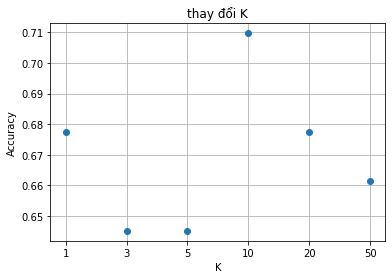

In [19]:
title = "thay đổi K"
xlabel = "K"
X = []
Y = []
error = []

for k in tqdm([1, 3, 5, 10, 20, 50]):
    # Load model
    model = KNN(top_k = k)
    model.fit(np.array(X_train), np.array(y_train))

    # Sample predict model
    y_pred = model.predict_batch(np.array(X_test))

    # Caculate accuracy score
    acc = accuracy_score(y_pred, np.array(y_test))

    X.append(str(k))
    Y.append(acc)
    error.append(0)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
# plt.savefig('images/KNN_change_K.png', bbox_inches='tight')
plt.show()

In [25]:
# Test mô hình với K=5, cho độ chính xác cao nhất
model = KNN(top_k = 10)

model.fit(np.array(X_train), np.array(y_train))

# Sample predict model
y_pred = model.predict_batch(np.array(X_test))

# Caculate accuracy score
acc = accuracy_score(y_pred, np.array(y_test))

acc

0.7096774193548387

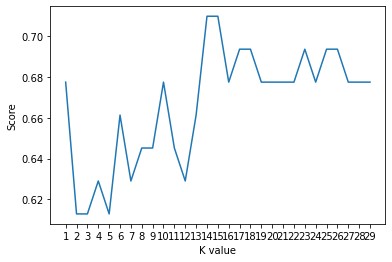

Maximum KNN Score is 70.97%


In [21]:
# try ro find best k value với thư viện KNeighborsClassifier
scoreList = []
for i in range(1,30):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(X_train, y_train)
    scoreList.append(knn2.score(X_test, y_test))
    
plt.plot(range(1,30), scoreList)
plt.xticks(np.arange(1,30,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100
print("Maximum KNN Score is {:.2f}%".format(acc))

KNN: 0.7096774193548387


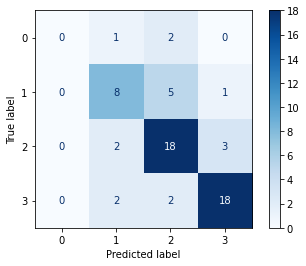

<Figure size 864x864 with 0 Axes>

In [26]:
# Test với bộ tham số tốt nhất
knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(X_train, y_train)

print(f'KNN: {accuracy_score(y_test, knn.predict(X_test))}')
# Hiển thị confusion matrix

plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues)  
plt.figure(figsize = (12, 12))
plt.show()

In [23]:
# Generating classification report
from sklearn.metrics import classification_report
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.62      0.57      0.59        14
           2       0.62      0.78      0.69        23
           3       0.85      0.77      0.81        22

    accuracy                           0.69        62
   macro avg       0.52      0.53      0.52        62
weighted avg       0.67      0.69      0.68        62



C:\Users\dovan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dovan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dovan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# from sklearn.metrics import precision_score, recall_score
# recall_s = recall_score(y_test, knn.predict(X_test), average=None)
# print('Tỉ lệ dự đoán đúng người bị bệnh là ', recall_s[1])
# print('Tỉ lệ dự đoán đúng người không bị bệnh là', recall_s[0])